In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc
import seaborn as sns

# %load_ext nb_black
use_cuda = True
sc.set_figure_params(dpi=200)

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import sys
sys.path.append('/home/angela/src/scVI_TSP/')
sys.path.append('/home/angela/sapiens/tabula-sapiens/')
# from utils.annotations_utils import *
from utils.colorDict import *
from utils.general_utils import *
from utils.plotting_utils import *

In [4]:
data_path = "/mnt/ibm_lg/angela/sapiens/data/"

In [5]:
adata = read_h5ad(data_path + "Pilot1_Pilot2.decontX.h5ad")
adata

AnnData object with n_obs × n_vars = 150084 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_metho

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.
/home/angela/.local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


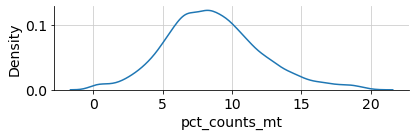

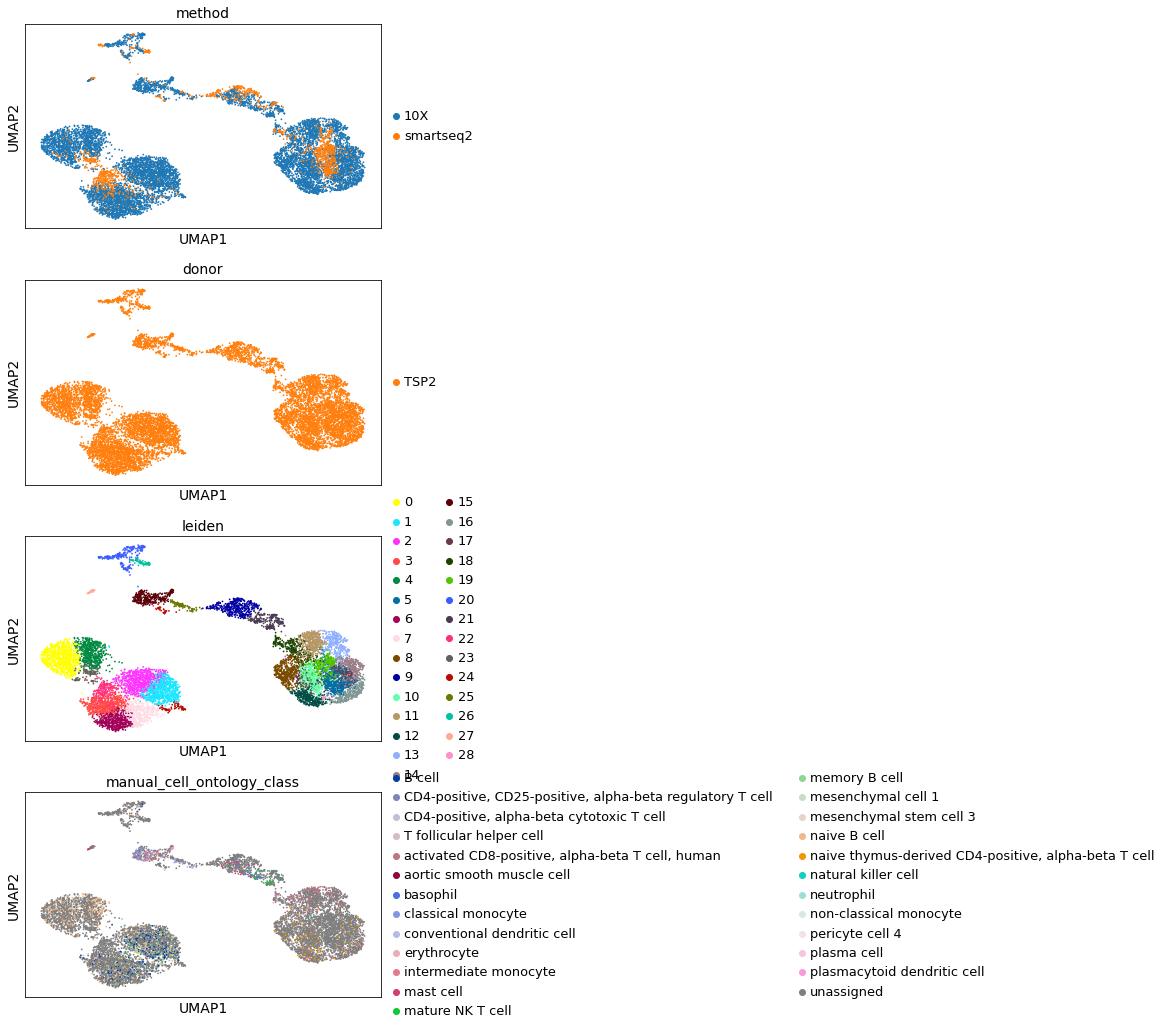

In [6]:
organ = "Lymph_Node"
organ_adata = adata[adata.obs["tissue"] == organ]

organ_adata.var['mt'] = organ_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(organ_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sns.displot(data=organ_adata.obs, x="pct_counts_mt", kind="kde", height=2, aspect=3)

# organ_adata = organ_adata[organ_adata.obs.pct_counts_mt < 20, :]

sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX", n_neighbors=15)
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=2)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [7]:
organ_adata

AnnData object with n_obs × n_vars = 9877 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method'

In [8]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

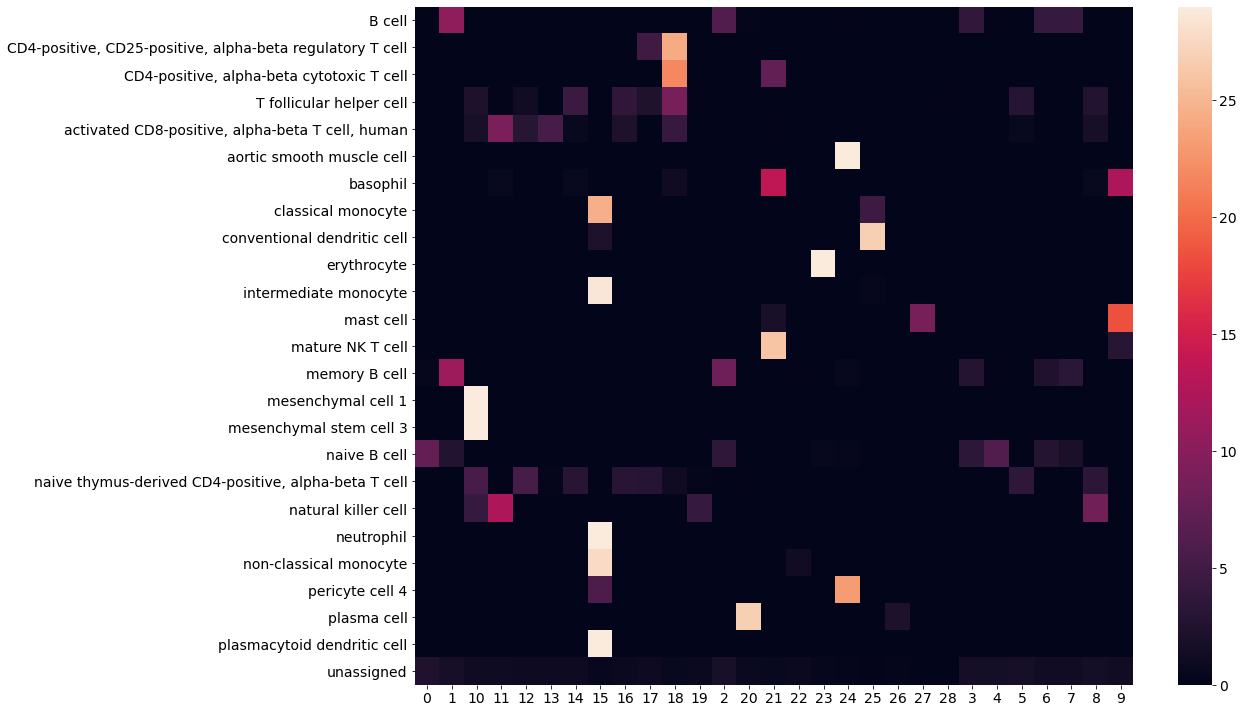

In [9]:
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap((count.T / count.mean(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [10]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [11]:
cluster_composition["8"]

['T follicular helper cell: 0.04',
 'activated CD8-positive, alpha-beta T cell, human: 0.05',
 'basophil: 0.00',
 'naive thymus-derived CD4-positive, alpha-beta T cell: 0.05',
 'natural killer cell: 0.00',
 'unassigned: 0.86']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [12]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [13]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

In [14]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


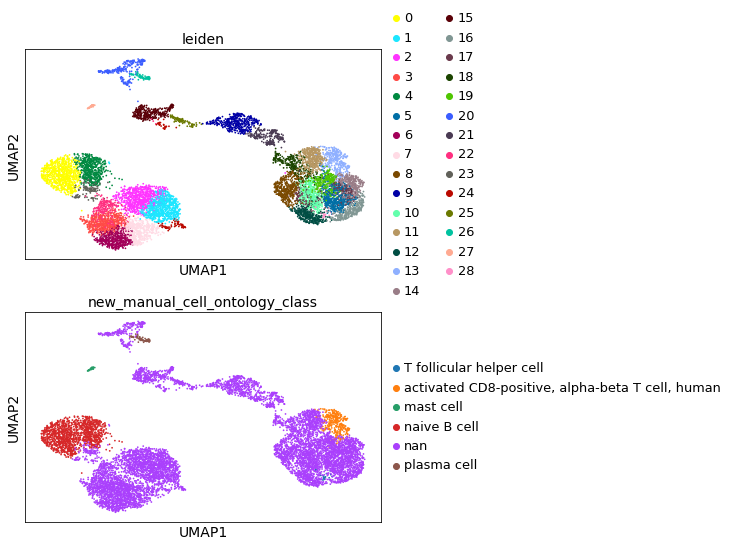

In [15]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

In [16]:
set(organ_adata.obs['Propagated.Annotation']),set(organ_adata.obs['manual_annotation'])

({'B cell',
  'CD4-positive helper T cell',
  'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
  'CD4-positive, alpha-beta cytotoxic T cell',
  'CD8-positive, alpha-beta T cell',
  'CD8-positive, alpha-beta memory T cell',
  'T cell',
  'T follicular helper cell',
  'activated CD8-positive, alpha-beta T cell, human',
  'aortic smooth muscle cell',
  'basophil',
  'cell',
  'classical monocyte',
  'conventional dendritic cell',
  'endothelial cell',
  'erythrocyte',
  'intermediate monocyte',
  'macrophage',
  'mast cell',
  'mature NK T cell',
  'memory B cell',
  'mesenchymal cell 1',
  'naive B cell',
  'naive thymus-derived CD4-positive, alpha-beta T cell',
  'natural killer cell',
  'non-classical monocyte',
  'pericyte cell 4',
  'plasma cell',
  'plasmacytoid dendritic cell'},
 {'B cell',
  'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
  'CD4-positive, alpha-beta cytotoxic T cell',
  'NK T cell',
  'NK cell',
  'T follicular helper cell',
  'activated C

In [17]:
organ_adata.obs.groupby(['leiden']).agg({'new_manual_cell_ontology_class':set,'Propagated.Annotation':set})

,new_manual_cell_ontology_class,Propagated.Annotation
leiden,,
0,{naive B cell},"{naive B cell, memory B cell, B cell}"
1,{nan},"{naive B cell, memory B cell, B cell}"
2,{nan},"{memory B cell, conventional dendritic cell, n..."
3,{nan},"{memory B cell, naive B cell, B cell}"
4,{naive B cell},"{naive B cell, memory B cell, B cell}"
5,{nan},"{naive thymus-derived CD4-positive, alpha-beta..."
6,{nan},"{memory B cell, naive B cell, B cell}"
7,{nan},"{naive B cell, memory B cell, B cell}"
8,{nan},"{naive thymus-derived CD4-positive, alpha-beta..."


/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


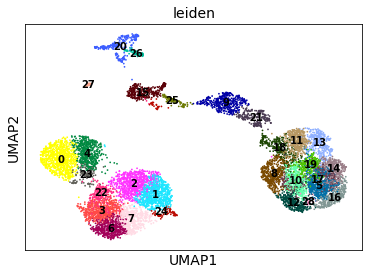

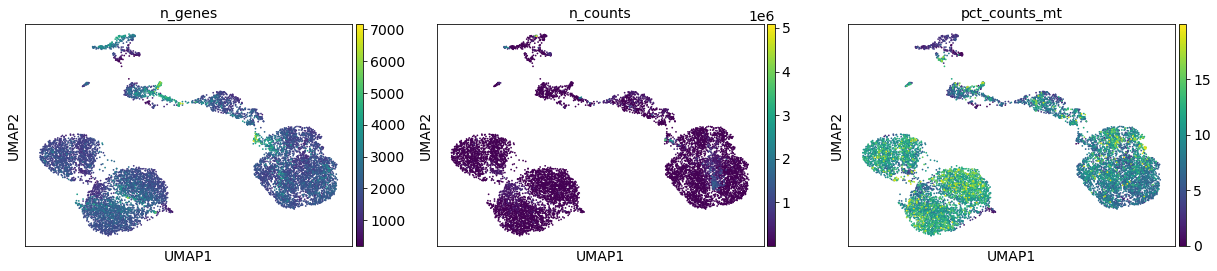

In [18]:
sc.pl.umap(organ_adata,color='leiden',legend_loc='on data')
sc.pl.umap(organ_adata,color=['n_genes','n_counts','pct_counts_mt'])


In [19]:
organ_adata.obs.columns

Index(['X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate',
       'smartseq2_sorting_direction', 'smartseq2_sort_order',
       'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate',
       'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes',
       'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position',
       'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class',
       'manual_annotation', 'doublet_filter', 'compartment', 'batch',
       'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation',
       'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps',
       'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet',
       'kNN', 'SVM', 'scANVI', 'compartment_pred_svm',
       'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed',
       'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed',
       'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized',
      

In [20]:
sc.tl.rank_genes_groups(organ_adata,'leiden',method='wilcoxon')

In [26]:
pd.set_option('display.max_columns', 30)

In [59]:
organ_cluster_genes = pd.DataFrame(organ_adata.uns['rank_genes_groups']['names'])

In [22]:
g = list(organ_cluster_genes["9"].head(10))
g = ",".join(g)
print(g)

AREG,NFKBIA,IL7R,TNFAIP3,ID2,FOS,ZFP36,ZFP36L2,RUNX2,FKBP5


In [23]:
set(organ_adata.obs[organ_adata.obs['leiden']=='7']['manual_annotation'])

{'B cell', 'memory B cell', 'naive B cell', 'unassigned'}

In [24]:
cluster_composition["14"]

['T follicular helper cell: 0.09',
 'activated CD8-positive, alpha-beta T cell, human: 0.03',
 'basophil: 0.00',
 'naive thymus-derived CD4-positive, alpha-beta T cell: 0.07',
 'unassigned: 0.82']

In [29]:
organ_cluster_genes.iloc[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,IGHD,HLA-DRA,TNFRSF13C,CD83,IGHD,RPS29,CD83,RPS29,IL7R,AREG,IL7R,CCL5,PRKCQ-AS1,CCL5,IL7R,S100A9,RPS29,IL6ST,IL32,EEF1A1P5,MZB1,KLRD1,CD74,IGHM,GPX1,CST3,MZB1,TPSB2,IL32
1,IGHM,HLA-DPB1,BANK1,BANK1,AL139020.1,IL7R,HSPA1A,RPL39,CD3E,NFKBIA,S100A4,GZMK,NOSIP,GZMA,BCL11B,LYZ,RPL37,CTLA4,CD3D,RPS3AP26,IGKC,NKG7,HLA-DRA,MS4A1,FABP5,LYZ,SSR4,TPSAB1,GIMAP7
2,AL139020.1,HLA-DPA1,MS4A1,MS4A1,IGHM,RPL37,JUND,HLA-DRA,CD3D,IL7R,IL32,GZMA,BCL11B,GZMK,DNAJB1,TYROBP,BCL11B,RTKN2,CD2,MALAT1,DERL3,GNLY,HLA-DRB1,IGHD,YBX1,HLA-DPB1,PRDX4,CPA3,CD3D
3,YBX3,MS4A1,BLK,IRF8,YBX3,RPS27,HSPA1B,MT-ND3,IL6ST,TNFAIP3,GIMAP7,CCL4,CD3E,CST7,ANXA1,AIF1,RPS21,BCL11B,CTLA4,TSC22D3,HDLBP,KLRF1,IRF8,FCRL1,HLA-DPB1,HLA-DPA1,DERL3,IL1RL1,LEPROTL1
4,CD83,HLA-DQA1,CD79B,TNFRSF13C,LINC00926,RPS26,MT-ND3,HLA-DPA1,CD2,ID2,TRAC,CST7,LDHB,CCL4,HSPA1B,CST3,RPS28,AAK1,TRAC,RPL13AP5,RRBP1,CMC1,TMSB4XP8,AL139020.1,PRDX1,GSTP1,SEC11C,KIT,LDHB
5,LINC00926,CD79A,CD79A,MT-ND3,CD79B,RPL39,KLF2,RPL37,CD3G,FOS,ARL4C,CCL3L1,CD3D,CCL3L1,AAK1,CD163,NOSIP,TIGIT,CD3E,FP671120.5,HSP90B1,KLRC1,MS4A1,CD74,TMSB4X,GPX1,FKBP11,LAPTM4A,PASK
6,LINC02397,NAPSB,RALGPS2,JUND,CD79A,TRAC,RHOB,RPS21,BCL11B,ZFP36,CD3D,NKG7,GYPC,DNAJB1,IL6ST,CEBPD,RPS26,ETS1,S100A4,SARAF,XBP1,CTSW,MT-ATP8,IRF8,FKBP1A,C1orf162,IGKC,CD63,LEF1
7,FCRL1,BLK,MARCH1,RALGPS2,STAG3,RPL34,IER5,HLA-DPB1,FYB1,ZFP36L2,CD3G,HCST,CD3G,DUSP2,ETS1,MS4A6A,RPL38,IL32,CD3G,DNAJB1,JCHAIN,PRF1,EEF1A1P5,HLA-DRA,COTL1,SPI1,XBP1,CD9,TRBC1
8,CD79A,SMIM14,HLA-DRA,LY9,RNASE6,RPL41,IRF8,HLA-DQA1,TRAC,RUNX2,ANXA1,IL32,NDFIP1,IL32,CD3E,FGL2,RPL39,CD3E,LCK,TMSB4XP8,SDF2L1,FCER1G,MALAT1,HLA-DRB1,HLA-DPA1,GRN,CD63,RHEX,CD3G
9,FCER2,MARCKS,ARHGAP24,KLF2,IL4R,DNAJB1,TNFRSF13C,RPS28,GIMAP7,FKBP5,CD3E,CD3D,LEPROTL1,HCST,FYB1,LST1,PRKCQ-AS1,TRAC,GMFG,B2M,PRDX4,TYROBP,MT-CO3,CD22,GAPDH,HLA-DRA,JCHAIN,CLU,TRAC


In [46]:
leiden_cell_type = {
    "0": "naive B cell", # IGHD,IGHM,CD20
    "1": "mature B cell", # CD20, HLA-DRA, HLA-DCB1, HLA-DPA1
    "2": "B cell", # CD20, CD79A, CD268
    "3": "B cell", # CD20, CD268
    "4": "naive B cell", # IGHD,IGHM,CD20
    "5": "CD4-positive, alpha-beta T cell", # CD3, IL7R,TRAC, CCR7, CD69 activated T Cell
    "6": "B cell", # CD20, CD83
    "7": "B cell", # CD20
    "8": "T cell", # CD3
    "9": "pre-pro B cell", # VPREB1
    "10": "memory T cell", # CD3, TRAC, CD62L-, CCR7-
    "11": "CD8-positive, alpha-beta T cell", # CD3, CD8
    "12": "T cell", #CD3
    "13": "CD8-positive, alpha-beta T cell", # CD3, CD8
    "14": "T cell", # CD3
    "15": "neutrophil", # cd14, cd16 (FCGR3A), HLA-DRA
    "16": "T cell", # CD3
    "17": "helper T cell", #CD4, CD3, CD69 Activated Helper T cells
    "18": "cytotoxic T cell", #CD4, CD8, CD69  Activated Cytotoxic T cells
    "19": "T cell", #CD4, CD25, FOXP3, CCR7,CD69 Activated, Treg /folliclular t cells
    "20": "plasma cell", #CD138 , CD38
    "21": "NK cell", #CD3-, NCAM1, NKG7, CD69 activated NK cell
    "22": "memory B cell", #CD19, CD20, CD27
    "23": "B cell", #CD19, CD20
    "24": "B cell", #CD19, CD20
    "25": "dendritic cell", #CD11C+, HLA-DRA, HLA-DP1
    "26": "plasma cell", #CD138, CD38
    "27": "mast cell", #TPSB2,TPSAB1
    "28": "T cell", #CD3, IL7R
}





# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [47]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()


This cell will automatically replace the leiden cluster names with cell type annotations

In [48]:
for l in leiden_cell_type.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, leiden_cell_type[l], inplace=True)

# Visualize the results of the manual annotation

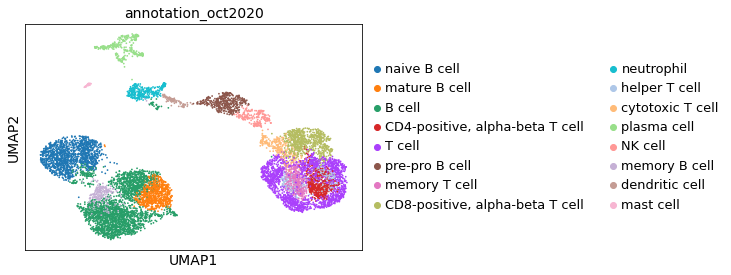

In [49]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# manually create mapping between cell type and compartment (this is just an example)

In [50]:
set(organ_adata.obs['annotation_oct2020'])

{'B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'NK cell',
 'T cell',
 'cytotoxic T cell',
 'dendritic cell',
 'helper T cell',
 'mast cell',
 'mature B cell',
 'memory B cell',
 'memory T cell',
 'naive B cell',
 'neutrophil',
 'plasma cell',
 'pre-pro B cell'}

In [51]:
organ_adata.obs["compartment_oct2020"] = "Immune"#organ_adata.obs["annotation_oct2020"].copy()

# Visualize the results of the new compartment splitting

... storing 'compartment_oct2020' as categorical


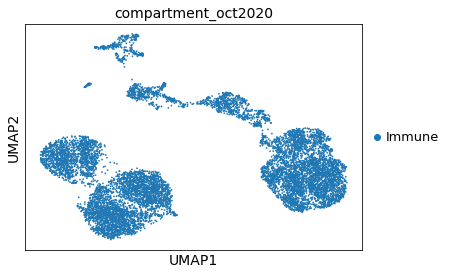

In [52]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# visualize compartment markers

In [53]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [44]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


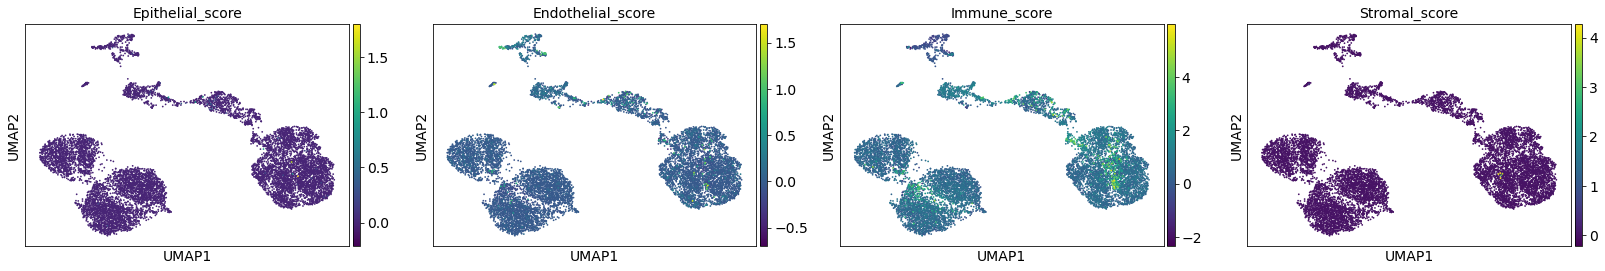

In [54]:
sc.pl.umap(
    organ_adata,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# save data

In [55]:
data_path

'/mnt/ibm_lg/angela/sapiens/data/'

In [56]:
organ_adata.write_h5ad(
    data_path + "decontX/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)